<a href="https://colab.research.google.com/github/MAboElFottouh/DeepLearning-/blob/main/Untitled21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import PIL

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#load data
## 10,000 images only 

In [3]:
images = []
path = '/content/drive/MyDrive/mini_celebA/1' 
for image in os.listdir(path):
  img = cv2.imread(path+'/'+image)
  images.append(img)

In [4]:
import numpy as np
images=np.array(images)
images.shape

(10000, 218, 178, 3)

#resize

In [5]:
def resizee(images):
  af_resize = []
  for image in images:
    af_resize.append(cv2.resize(image,(64,64)))
  return af_resize

In [6]:
resizee = resizee(images)




```
# make pxial between 0 . 1 
```



In [7]:
normalized = np.array(resizee)/255
train_dataset = tf.data.Dataset.from_tensor_slices(normalized).batch(256)

In [8]:
normalized.shape

(10000, 64, 64, 3)

In [9]:
#Display first 25 images
import matplotlib.pyplot as plt

plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    #cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)
    plt.imshow(cv2.cvtColor(resizee[i], cv2.COLOR_RGB2BGR)) ##plt show BGR 
    plt.axis('off')
plt.show()

In [10]:
# take this function from tensorflow websit
# and kaggle
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Conv2D,Dropout,Dense,Conv2DTranspose,Reshape,BatchNormalization,LeakyReLU

def make_generator_model():
    model = Sequential()
    model.add(Dense(4*4*512, input_shape=(100,)))
    model.add(Reshape((4, 4, 512)))
    model.add(Conv2DTranspose(256, 5, strides=2, padding='same'))

    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(128, 4, strides=2, padding='same'))

    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(64, 4, strides=2, padding='same'))

    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(3, 4, strides=2, padding='same',activation='sigmoid'))

    return model


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        3277056   
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 256)         0         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      5

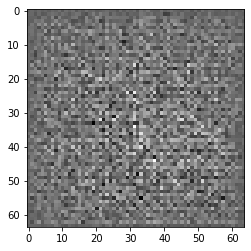

In [11]:
from tensorflow.keras import layers
generator = make_generator_model()
print(generator.summary())
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [12]:
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(32, 4, 2, padding='same', input_shape=(64, 64, 3)))
    model.add(Conv2D(64, 4, 2, padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Conv2D(128, 4,2, padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Conv2D(256, 4,2, padding='same'))
    model.add(LeakyReLU())
    model.add(Flatten())
    model.add(Dropout(0.5))

    model.add(Dense(1,activation='sigmoid'))

    return model

In [15]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        1568      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        32832     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                      

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss, real_loss, fake_loss

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(0.001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.001)

#Define the training loop

In [19]:
import time
EPOCHS = 50
noise_dim = 100     
num_examples_to_generate = 16
BATCH_SIZE = 256
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [20]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [21]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss, real_loss, fake_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss, real_loss, fake_loss

In [22]:
def train(dataset, epochs):
  gen_hist = []
  disc_hist = []
  disc_real_hist = []
  disc_fake_hist = []
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      g_loss, d_loss, d_real_loss, d_fake_loss = train_step(image_batch)
      g_loss = g_loss.numpy()
      d_loss = d_loss.numpy()
      d_real_loss = d_real_loss.numpy()
      d_fake_loss = d_fake_loss.numpy()
      gen_hist.append(g_loss)
      disc_hist.append(d_loss)
      disc_real_hist.append(d_real_loss)
      disc_fake_hist.append(d_fake_loss)
    print("G_loss:", g_loss, "D_loss:", d_real_loss, d_fake_loss, d_loss)

    # Produce images for the GIF as you go
    # display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  plot_history(disc_real_hist, disc_fake_hist, disc_hist, gen_hist)

In [23]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [24]:
def plot_history(d1_hist, d2_hist, d_hist, g_hist):
  # plot loss
  plt.plot(d1_hist, label='d-real')
  plt.plot(d2_hist, label='d-fake')
  plt.plot(d_hist, label='d-total')
  plt.plot(g_hist, label='gen')
  plt.legend()
  # save plot to file
  plt.savefig('plot_loss.png')
  plt.show()
  plt.close()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


G_loss: 6.093395 D_loss: 0.26742905 0.17523603 0.4426651


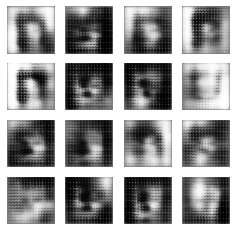

Time for epoch 1 is 12.74501371383667 sec
G_loss: 6.295142 D_loss: 0.10152277 0.3656057 0.4671285


Time for epoch 2 is 6.930510759353638 sec
G_loss: 7.3779964 D_loss: 0.004264476 0.15045288 0.15471736


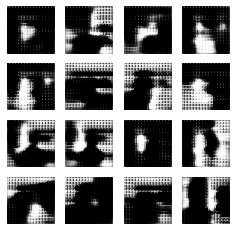

Time for epoch 3 is 7.102725028991699 sec
G_loss: 7.1773925 D_loss: 2.875387e-05 0.2851976 0.28522635


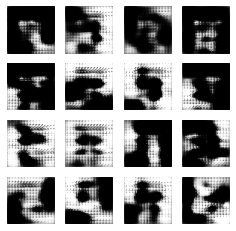

Time for epoch 4 is 10.959623336791992 sec
G_loss: 10.027451 D_loss: 0.06651217 0.019304585 0.085816756


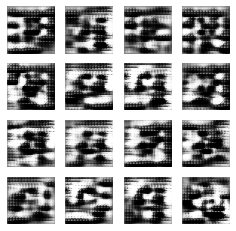

Time for epoch 5 is 7.145068883895874 sec
G_loss: 9.083412 D_loss: 1.0235854 0.1017858 1.1253712


Time for epoch 6 is 7.1424033641815186 sec
G_loss: 12.715195 D_loss: 0.0021884476 0.0014315653 0.003620013


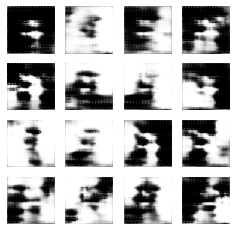

Time for epoch 7 is 7.3669657707214355 sec
G_loss: 8.255666 D_loss: 0.0044489694 0.034784514 0.039233483


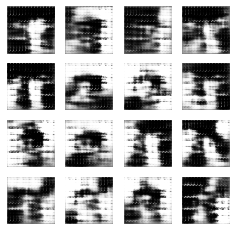

Time for epoch 8 is 7.265931606292725 sec
G_loss: 4.785264 D_loss: 0.00055465737 0.35306984 0.3536245


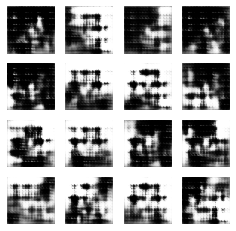

Time for epoch 9 is 7.344179630279541 sec
G_loss: 5.567494 D_loss: 0.14711028 0.2675206 0.4146309


Time for epoch 10 is 7.4535064697265625 sec
G_loss: 10.193751 D_loss: 0.0011503549 0.017788857 0.018939212


Time for epoch 11 is 7.761355638504028 sec
G_loss: 8.519163 D_loss: 0.00065567903 0.06730511 0.06796079


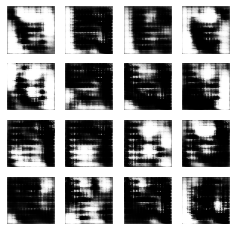

Time for epoch 12 is 7.511292219161987 sec
G_loss: 10.94207 D_loss: 0.072243825 0.0049010217 0.07714485


Time for epoch 13 is 7.40826678276062 sec
G_loss: 10.36215 D_loss: 0.41704604 0.0018943902 0.41894042


Time for epoch 14 is 7.3387298583984375 sec
G_loss: 10.285347 D_loss: 0.008035346 0.12992713 0.13796248


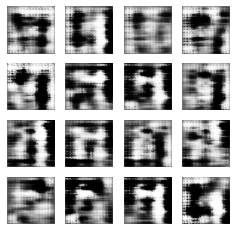

Time for epoch 15 is 7.77493691444397 sec
G_loss: 7.4707613 D_loss: 8.750681e-05 0.061110422 0.06119793


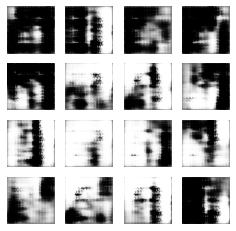

Time for epoch 16 is 7.240646123886108 sec
G_loss: 8.446693 D_loss: 0.00023915069 0.0690662 0.069305345


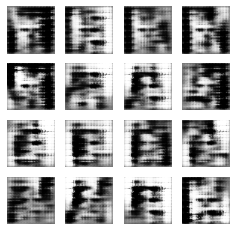

Time for epoch 17 is 7.27685809135437 sec
G_loss: 9.251357 D_loss: 0.0006056987 0.028490674 0.029096372


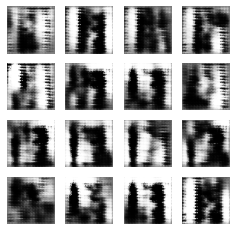

Time for epoch 18 is 7.501648664474487 sec
G_loss: 3.9024487 D_loss: 0.00013058874 0.3648639 0.3649945


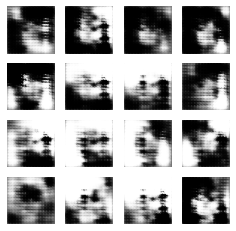

Time for epoch 19 is 7.327082633972168 sec
G_loss: 11.476328 D_loss: 3.1283507e-05 0.018037008 0.018068291


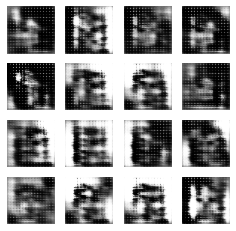

Time for epoch 20 is 7.329168081283569 sec
G_loss: 10.415766 D_loss: 3.2661242e-06 0.010912316 0.010915582


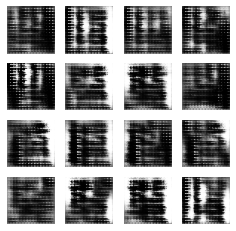

Time for epoch 21 is 7.35703444480896 sec
G_loss: 12.251987 D_loss: 0.00021198751 0.10201526 0.10222724


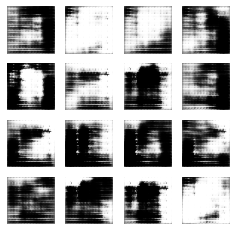

Time for epoch 22 is 7.586363077163696 sec
G_loss: 8.872347 D_loss: 2.8060274e-05 0.04693911 0.046967167


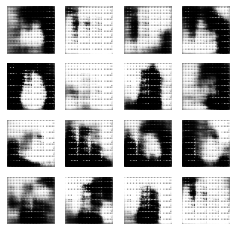

Time for epoch 23 is 7.360919713973999 sec
G_loss: 4.9389815 D_loss: 0.0131444875 0.16311473 0.17625922


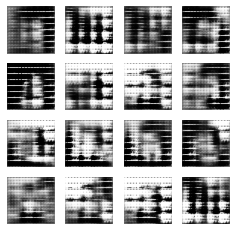

Time for epoch 24 is 7.380030632019043 sec
G_loss: 11.276859 D_loss: 0.0006850354 0.047152944 0.04783798


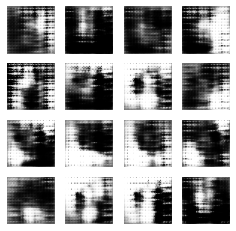

Time for epoch 25 is 7.353158473968506 sec
G_loss: 9.711053 D_loss: 0.0015240402 0.0024263535 0.0039503938


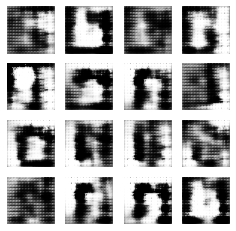

Time for epoch 26 is 7.595837354660034 sec
G_loss: 7.9976864 D_loss: 0.04381235 0.0881464 0.13195875


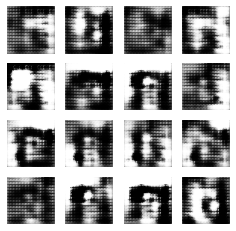

Time for epoch 27 is 7.325092077255249 sec
G_loss: 9.315994 D_loss: 0.0002539644 0.06138767 0.061641634


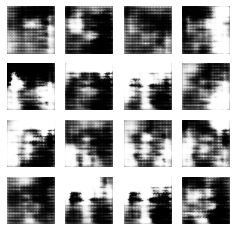

Time for epoch 28 is 7.339101791381836 sec
G_loss: 7.631672 D_loss: 0.09068077 0.0881227 0.17880347


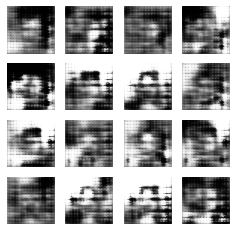

Time for epoch 29 is 7.5418701171875 sec
G_loss: 9.270912 D_loss: 0.03008727 0.05722482 0.08731209


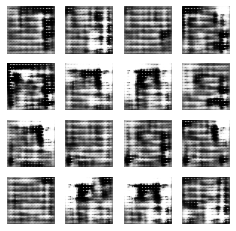

Time for epoch 30 is 7.591251611709595 sec
G_loss: 16.287708 D_loss: 0.015904492 0.00093907426 0.016843567


Time for epoch 31 is 7.335272789001465 sec
G_loss: 6.2554607 D_loss: 0.17471124 0.083563656 0.2582749


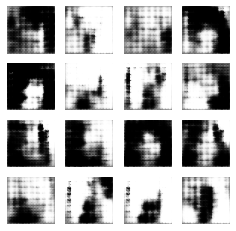

Time for epoch 32 is 7.341729640960693 sec
G_loss: 7.6703577 D_loss: 0.07840308 0.0363822 0.11478528


Time for epoch 33 is 7.574147939682007 sec
G_loss: 4.6024756 D_loss: 0.6814523 0.84709126 1.5285435


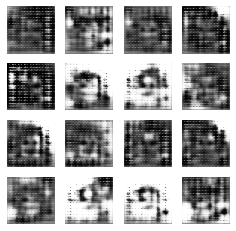

Time for epoch 34 is 7.368882179260254 sec
G_loss: 6.340171 D_loss: 0.41545022 0.05944983 0.47490004


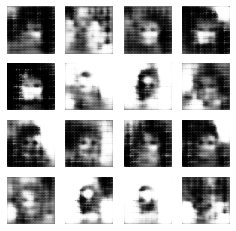

Time for epoch 35 is 7.412762641906738 sec
G_loss: 7.4572053 D_loss: 1.3242588 0.034604196 1.358863


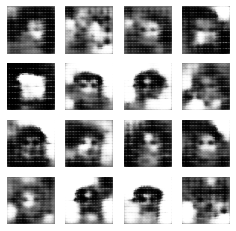

Time for epoch 36 is 7.36396861076355 sec
G_loss: 8.324041 D_loss: 0.07206808 0.022758897 0.09482698


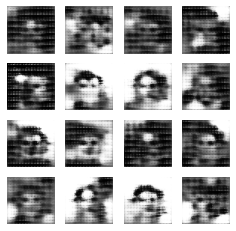

Time for epoch 37 is 7.560084819793701 sec
G_loss: 9.130029 D_loss: 0.17480151 0.008606161 0.18340768


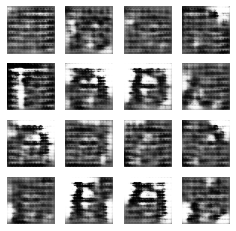

Time for epoch 38 is 7.351623296737671 sec
G_loss: 13.593235 D_loss: 7.082487 0.017241083 7.099728


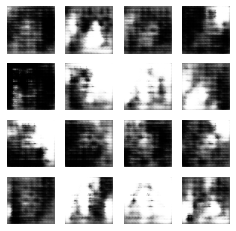

Time for epoch 39 is 7.355602025985718 sec
G_loss: 6.619713 D_loss: 0.1778799 0.077791765 0.25567168


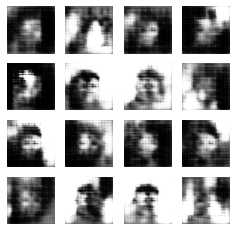

Time for epoch 40 is 7.568622827529907 sec
G_loss: 8.457759 D_loss: 0.008717829 0.09185911 0.10057694


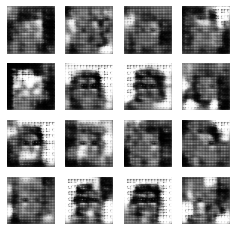

Time for epoch 41 is 7.361237525939941 sec
G_loss: 6.899511 D_loss: 0.040700343 0.11825591 0.15895626


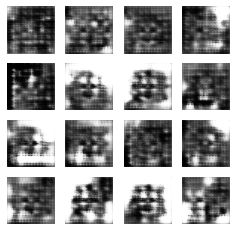

Time for epoch 42 is 7.353168249130249 sec
G_loss: 4.903349 D_loss: 0.23726732 0.25744614 0.49471346


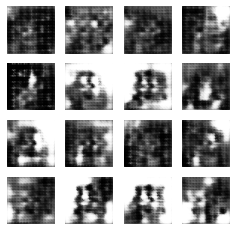

Time for epoch 43 is 7.359189033508301 sec
G_loss: 7.6560354 D_loss: 0.08229808 0.02108121 0.10337929


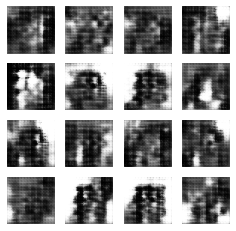

Time for epoch 44 is 7.578270435333252 sec
G_loss: 9.407143 D_loss: 0.018507022 0.0026500863 0.021157108


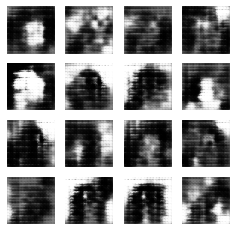

Time for epoch 45 is 7.627141237258911 sec
G_loss: 6.9871526 D_loss: 0.012090225 0.039913677 0.0520039


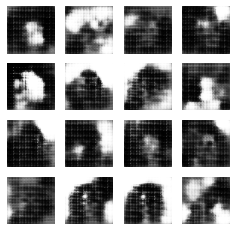

Time for epoch 46 is 7.39002537727356 sec
G_loss: 10.962734 D_loss: 0.0033704583 0.00092026533 0.0042907237


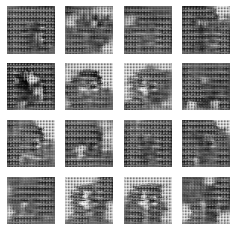

Time for epoch 47 is 7.582167387008667 sec
G_loss: 10.419444 D_loss: 0.00044363778 0.0062140464 0.006657684


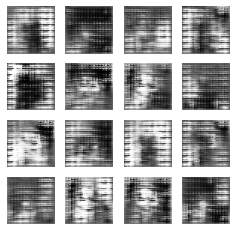

Time for epoch 48 is 7.336745500564575 sec


In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
|